#IMPORT NECESSARY LIBRARIES

In [1]:
import os
import random
random.seed(42) # Set random seed for reproducibility
import time
import math
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_1442615/2250032840.py:11: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
from mpl_toolkits.mplot3d import Axes3D
from skimage import io
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import VotingClassifier
from imblearn.over_sampling import RandomOverSampler
import imgaug.augmenters as iaa

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, OneCycleLR
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.multiprocessing as mp
from torchvision import models, transforms
from PIL import Image
from tqdm import tqdm

/storage/phucpg/venv/v1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# !pip install efficientnet_pytorch
# !pip install pytorch-dpn-pretrained
from efficientnet_pytorch import EfficientNet
import torch.hub

##Define runtime

In [5]:
# !pip install ipython-autotime
%load_ext autotime

time: 211 µs (started: 2024-08-18 19:04:29 +07:00)


##Define GPU usage

In [6]:
print("Available GPUs:")
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")


Available GPUs:
GPU 0: Tesla K80
GPU 1: Tesla K80
GPU 2: Tesla K80
GPU 3: Tesla K80
GPU 4: Tesla K80
GPU 5: Tesla K80
GPU 6: Tesla K80
GPU 7: Tesla K80
time: 82.9 ms (started: 2024-08-18 19:04:29 +07:00)


In [7]:
# Set the GPU device
gpu_index = 2  # Change the index for each file (0 to 7)
if gpu_index < torch.cuda.device_count():
    torch.cuda.set_device(gpu_index)
    device = torch.device(f"cuda:{gpu_index}")
    print(f"Using GPU {gpu_index}: {torch.cuda.get_device_name(gpu_index)}")
else:
    print(f"Invalid GPU index: {gpu_index}. Please choose an index between 0 and {torch.cuda.device_count() - 1}.")


Using GPU 2: Tesla K80
time: 2.77 ms (started: 2024-08-18 19:04:29 +07:00)


#DATA PREPARATION

##Get and Import dataset

In [8]:
data_dir = '../data/ISIC_2019'

training_input_zip = data_dir + '/ISIC_2019_Training_Input.zip'
test_input_zip = data_dir + '/ISIC_2019_Test_Input.zip'

training_Metadata = data_dir + '/ISIC_2019_Training_Metadata.csv'
training_GroundTruth =  data_dir + '/ISIC_2019_Training_GroundTruth.csv'
test_Metadata = data_dir + '/ISIC_2019_Test_Metadata.csv'

# !unzip "$training_input_zip"
# !unzip "$test_input_zip"

training_input_dir = data_dir + '/ISIC_2019_Training_Input'
test_input_dir = data_dir + '/ISIC_2019_Test_Input'

time: 1.89 ms (started: 2024-08-18 19:04:29 +07:00)


###Meta-data

In [9]:
train_metadata=pd.read_csv(training_Metadata)
train_metadata

,image,age_approx,anatom_site_general,lesion_id,sex
0,ISIC_0000000,55.0,anterior torso,NaN,female
1,ISIC_0000001,30.0,anterior torso,NaN,female
2,ISIC_0000002,60.0,upper extremity,NaN,female
3,ISIC_0000003,30.0,upper extremity,NaN,male
4,ISIC_0000004,80.0,posterior torso,NaN,male
...,...,...,...,...,...
25326,ISIC_0073247,85.0,head/neck,BCN_0003925,female
25327,ISIC_0073248,65.0,anterior torso,BCN_0001819,male
25328,ISIC_0073249,70.0,lower extremity,BCN_0001085,male
25329,ISIC_0073251,55.0,palms/soles,BCN_0002083,female


time: 59.7 ms (started: 2024-08-18 19:04:29 +07:00)


In [10]:
train_groundtruth=pd.read_csv(training_GroundTruth)
# # Drop the 'UNK' column
# train_groundtruth = train_groundtruth.drop(columns=['UNK'])
train_groundtruth

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
25327,ISIC_0073248,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
25328,ISIC_0073249,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25329,ISIC_0073251,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


time: 71.9 ms (started: 2024-08-18 19:04:29 +07:00)


In [11]:
test_metadata=pd.read_csv(test_Metadata)
test_metadata

,image,age_approx,anatom_site_general,sex
0,ISIC_0034321,60.0,NaN,female
1,ISIC_0034322,70.0,anterior torso,male
2,ISIC_0034323,70.0,lower extremity,male
3,ISIC_0034324,70.0,lower extremity,male
4,ISIC_0034325,30.0,upper extremity,female
...,...,...,...,...
8233,ISIC_0073236,75.0,anterior torso,male
8234,ISIC_0073243,65.0,lower extremity,male
8235,ISIC_0073250,30.0,anterior torso,female
8236,ISIC_0073252,85.0,head/neck,female


time: 22.5 ms (started: 2024-08-18 19:04:29 +07:00)


###Meta-data information

In [12]:
train_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   image                25331 non-null  object 
 1   age_approx           24894 non-null  float64
 2   anatom_site_general  22700 non-null  object 
 3   lesion_id            23247 non-null  object 
 4   sex                  24947 non-null  object 
dtypes: float64(1), object(4)
memory usage: 989.6+ KB
time: 14.1 ms (started: 2024-08-18 19:04:29 +07:00)


In [13]:
train_groundtruth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   image   25331 non-null  object 
 1   MEL     25331 non-null  float64
 2   NV      25331 non-null  float64
 3   BCC     25331 non-null  float64
 4   AK      25331 non-null  float64
 5   BKL     25331 non-null  float64
 6   DF      25331 non-null  float64
 7   VASC    25331 non-null  float64
 8   SCC     25331 non-null  float64
 9   UNK     25331 non-null  float64
dtypes: float64(9), object(1)
memory usage: 1.9+ MB
time: 10.6 ms (started: 2024-08-18 19:04:29 +07:00)


In [14]:
test_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8238 entries, 0 to 8237
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   image                8238 non-null   object 
 1   age_approx           7912 non-null   float64
 2   anatom_site_general  7583 non-null   object 
 3   sex                  7899 non-null   object 
dtypes: float64(1), object(3)
memory usage: 257.6+ KB
time: 11.3 ms (started: 2024-08-18 19:04:29 +07:00)


##DATA PREPROCESSING

###Original data information

In [15]:
train_metadata.info()
print()
# train_metadata.head()
print(train_metadata.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   image                25331 non-null  object 
 1   age_approx           24894 non-null  float64
 2   anatom_site_general  22700 non-null  object 
 3   lesion_id            23247 non-null  object 
 4   sex                  24947 non-null  object 
dtypes: float64(1), object(4)
memory usage: 989.6+ KB

Index(['image', 'age_approx', 'anatom_site_general', 'lesion_id', 'sex'], dtype='object')
time: 16.7 ms (started: 2024-08-18 19:04:29 +07:00)


###Data cleansing

identifying and correcting errors or inconsistencies in the data.

In [16]:
# Convert the train_groundtruth DataFrame from wide format to long format
melted_groundtruth = train_groundtruth.melt(id_vars='image', var_name='disease_type', value_name='presence')


# THIS LINE REMOVE UNK COLUMN
# Filter out rows where presence is 0 (i.e., the disease type is not present)
filtered_groundtruth = melted_groundtruth[melted_groundtruth['presence'] == 1]

# Merge the train_metadata and filtered_groundtruth DataFrames on the 'image' column
combined_train_df = pd.merge(train_metadata, filtered_groundtruth, on='image')

print(combined_train_df.columns)

Index(['image', 'age_approx', 'anatom_site_general', 'lesion_id', 'sex',
       'disease_type', 'presence'],
      dtype='object')
time: 72.2 ms (started: 2024-08-18 19:04:30 +07:00)


In [17]:
# Removing duplicate rows
train_metadata_pp = combined_train_df.drop_duplicates()

# Removing rows with missing values
train_metadata_pp = train_metadata_pp.dropna()

# Replace missing values in 'age' column with median age
median_age = train_metadata_pp['age_approx'].median()
train_metadata_pp['age_approx'] = train_metadata_pp['age_approx'].fillna(median_age)

# Fixing column names
train_metadata_pp = train_metadata_pp.rename(columns={
    'image': 'Image_Id',
    'age_approx': 'Age',
    'anatom_site_general': 'Region_Of_Disease',
    'lesion_id': 'Lesion_Id',
    'sex': 'Sex',
    'disease_type': 'Disease_Type',
    'presence': 'Presence'
})

# Define the mapping of current values to new values
diagnosis_mapping = {
    'MEL': 'Melanoma',
    'NV': 'Melanocytic Nevi',
    'BCC': 'Basal Cell Carcinoma',
    'AK': 'Actinic Keratoses',
    'BKL': 'Benign Keratosis-Like Lesions',
    'DF': 'Dermatofibroma',
    'VASC': 'Vascular Lesions',
    'SCC': 'Squamous Cell Carcinoma',
    'UNK': 'Unknown'
}

# Convert the Age column to integers
train_metadata_pp['Age'] = train_metadata_pp['Age'].astype(int)

# Create a new column with the updated diagnosis names
train_metadata_pp['Diagnosis'] = train_metadata_pp['Disease_Type'].map(diagnosis_mapping)

time: 53.8 ms (started: 2024-08-18 19:04:30 +07:00)


In [18]:
train_metadata_pp.info()
print()
train_metadata_pp

<class 'pandas.core.frame.DataFrame'>
Index: 21311 entries, 1459 to 25330
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Image_Id           21311 non-null  object 
 1   Age                21311 non-null  int64  
 2   Region_Of_Disease  21311 non-null  object 
 3   Lesion_Id          21311 non-null  object 
 4   Sex                21311 non-null  object 
 5   Disease_Type       21311 non-null  object 
 6   Presence           21311 non-null  float64
 7   Diagnosis          21311 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 1.5+ MB



,Image_Id,Age,Region_Of_Disease,Lesion_Id,Sex,Disease_Type,Presence,Diagnosis
1459,ISIC_0012653_downsampled,50,posterior torso,MSK4_0011169,female,NV,1.0,Melanocytic Nevi
1460,ISIC_0012654_downsampled,30,lower extremity,MSK4_0011170,female,NV,1.0,Melanocytic Nevi
1461,ISIC_0012655_downsampled,35,upper extremity,MSK4_0011171,female,NV,1.0,Melanocytic Nevi
1462,ISIC_0012656_downsampled,45,posterior torso,MSK4_0011172,male,NV,1.0,Melanocytic Nevi
1463,ISIC_0012657_downsampled,20,upper extremity,MSK4_0011173,female,NV,1.0,Melanocytic Nevi
...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,85,head/neck,BCN_0003925,female,BCC,1.0,Basal Cell Carcinoma
25327,ISIC_0073248,65,anterior torso,BCN_0001819,male,BKL,1.0,Benign Keratosis-Like Lesions
25328,ISIC_0073249,70,lower extremity,BCN_0001085,male,MEL,1.0,Melanoma
25329,ISIC_0073251,55,palms/soles,BCN_0002083,female,NV,1.0,Melanocytic Nevi


time: 35.7 ms (started: 2024-08-18 19:04:30 +07:00)


###Get images data

finish preprocessing

In [19]:
# Map image paths
train_image_dir = training_input_dir
image_paths = [os.path.join(train_image_dir, fname) for fname in os.listdir(train_image_dir)]
image_path_dict = {os.path.splitext(os.path.basename(p))[0]: p for p in image_paths}
train_metadata_pp['Image_path'] = train_metadata_pp['Image_Id'].map(image_path_dict)

train_metadata_pp

,Image_Id,Age,Region_Of_Disease,Lesion_Id,Sex,Disease_Type,Presence,Diagnosis,Image_path
1459,ISIC_0012653_downsampled,50,posterior torso,MSK4_0011169,female,NV,1.0,Melanocytic Nevi,../data/ISIC_2019/ISIC_2019_Training_Input/ISI...
1460,ISIC_0012654_downsampled,30,lower extremity,MSK4_0011170,female,NV,1.0,Melanocytic Nevi,../data/ISIC_2019/ISIC_2019_Training_Input/ISI...
1461,ISIC_0012655_downsampled,35,upper extremity,MSK4_0011171,female,NV,1.0,Melanocytic Nevi,../data/ISIC_2019/ISIC_2019_Training_Input/ISI...
1462,ISIC_0012656_downsampled,45,posterior torso,MSK4_0011172,male,NV,1.0,Melanocytic Nevi,../data/ISIC_2019/ISIC_2019_Training_Input/ISI...
1463,ISIC_0012657_downsampled,20,upper extremity,MSK4_0011173,female,NV,1.0,Melanocytic Nevi,../data/ISIC_2019/ISIC_2019_Training_Input/ISI...
...,...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,85,head/neck,BCN_0003925,female,BCC,1.0,Basal Cell Carcinoma,../data/ISIC_2019/ISIC_2019_Training_Input/ISI...
25327,ISIC_0073248,65,anterior torso,BCN_0001819,male,BKL,1.0,Benign Keratosis-Like Lesions,../data/ISIC_2019/ISIC_2019_Training_Input/ISI...
25328,ISIC_0073249,70,lower extremity,BCN_0001085,male,MEL,1.0,Melanoma,../data/ISIC_2019/ISIC_2019_Training_Input/ISI...
25329,ISIC_0073251,55,palms/soles,BCN_0002083,female,NV,1.0,Melanocytic Nevi,../data/ISIC_2019/ISIC_2019_Training_Input/ISI...


time: 9.23 s (started: 2024-08-18 19:04:30 +07:00)


In [20]:
# train_metadata_pp = train_metadata_pp.sample(n=2000, random_state=42) # remove this line for full dataset
train_metadata_pp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21311 entries, 1459 to 25330
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Image_Id           21311 non-null  object 
 1   Age                21311 non-null  int64  
 2   Region_Of_Disease  21311 non-null  object 
 3   Lesion_Id          21311 non-null  object 
 4   Sex                21311 non-null  object 
 5   Disease_Type       21311 non-null  object 
 6   Presence           21311 non-null  float64
 7   Diagnosis          21311 non-null  object 
 8   Image_path         21311 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 1.6+ MB
time: 17 ms (started: 2024-08-18 19:04:39 +07:00)


###Correctting image paths

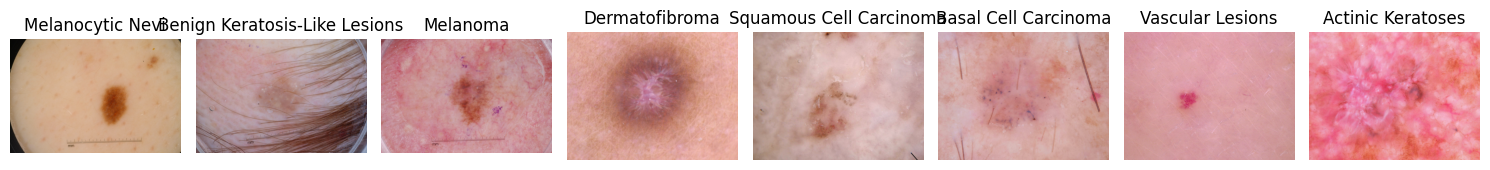

time: 28.8 s (started: 2024-08-18 19:04:39 +07:00)


In [21]:
# Ensure that the image paths are correct and accessible
for i in range(len(train_metadata_pp)):
    if not os.path.isfile(train_metadata_pp['Image_path'].iloc[i]):
        raise FileNotFoundError(f"Image file not found: {train_metadata_pp['Image_path'].iloc[i]}")

# Get one image per class
class_images = train_metadata_pp.drop_duplicates(subset='Diagnosis')

# Plot one image per class
def plot_class_images(class_images):
    plt.figure(figsize=(15, 5))
    num_classes = len(class_images)
    for i in range(num_classes):
        plt.subplot(1, num_classes, i + 1)
        img = plt.imread(class_images['Image_path'].iloc[i])
        plt.imshow(img)
        plt.axis('off')
        plt.title(class_images['Diagnosis'].iloc[i], fontsize=12)
    plt.tight_layout()
    plt.show()

# Call the function to plot images
plot_class_images(class_images)

#MODEL IMPLEMENTATION

##Prepare data for training process

###Label Encoder

In [22]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit LabelEncoder and transform 'Region_Of_Disease' column
train_metadata_pp['Diagnosis_Label'] = label_encoder.fit_transform(train_metadata_pp['Diagnosis'])

# Display the mapping between original labels and encoded labels
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Encoding Mapping:")
print(label_mapping)

Label Encoding Mapping:
{'Actinic Keratoses': 0, 'Basal Cell Carcinoma': 1, 'Benign Keratosis-Like Lesions': 2, 'Dermatofibroma': 3, 'Melanocytic Nevi': 4, 'Melanoma': 5, 'Squamous Cell Carcinoma': 6, 'Vascular Lesions': 7}
time: 11.2 ms (started: 2024-08-18 19:05:08 +07:00)


###Augment and transfrom dataset

In [23]:
# Data augmentation and transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert PIL image to tensor
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

time: 10.9 ms (started: 2024-08-18 19:05:08 +07:00)


###Split data

In [24]:
# Split the dataset into train and temp (80% train, 20% temp)
train_df, temp_df = train_test_split(train_metadata_pp, test_size=0.2, stratify=train_metadata_pp['Diagnosis_Label'], random_state=42)

# Split the temp dataset into validation and test (50% val, 50% test of the 20% temp)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['Diagnosis_Label'], random_state=42)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 17048
Validation set size: 2131
Test set size: 2132
time: 22 ms (started: 2024-08-18 19:05:08 +07:00)


###Balancing dataset

In [25]:
# Separate features and labels for balancing
X_train = train_df.drop(columns=['Diagnosis_Label'])
y_train = train_df['Diagnosis_Label']

# Apply RandomOverSampler only to the training set
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# Combine resampled features and labels into a DataFrame
train_df_resampled = X_resampled.copy()
train_df_resampled['Diagnosis_Label'] = y_resampled

print(f"Resampled training set size: {len(train_df_resampled)}")

Resampled training set size: 62368
time: 74.5 ms (started: 2024-08-18 19:05:08 +07:00)


###Load dataset

In [26]:
#  make easily load and preprocess dataset -> compatible with PyTorch’s data loading utilities.
class LoadedDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['Image_path']
        image = Image.open(img_path).convert('RGB')
        label = self.dataframe.iloc[idx]['Diagnosis_Label']

        if self.transform:
            image = self.transform(image)

        return image, label

# Create datasets and dataloaders
train_dataset = LoadedDataset(train_df_resampled, transform=transform)
val_dataset = LoadedDataset(val_df, transform=transform)
test_dataset = LoadedDataset(test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, persistent_workers=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, persistent_workers=True)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, persistent_workers=True)

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, persistent_workers=True, pin_memory=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, persistent_workers=True, pin_memory=True)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, persistent_workers=True, pin_memory=True)

# Example of iterating through the dataloader and printing results
for images, labels in train_loader:
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch of labels shape: {labels.shape}")
    print(f"Labels: {labels}")

    print("Label Mapping:", label_mapping)
    print("Unique Labels in Dataset:", train_metadata_pp['Diagnosis_Label'].unique())

    break  # Print only the first batch

Batch of images shape: torch.Size([32, 3, 224, 224])
Batch of labels shape: torch.Size([32])
Labels: tensor([7, 3, 0, 0, 3, 7, 3, 6, 0, 1, 2, 6, 0, 2, 7, 0, 4, 3, 3, 5, 3, 7, 4, 5,
        5, 3, 3, 0, 4, 2, 4, 3])
Label Mapping: {'Actinic Keratoses': 0, 'Basal Cell Carcinoma': 1, 'Benign Keratosis-Like Lesions': 2, 'Dermatofibroma': 3, 'Melanocytic Nevi': 4, 'Melanoma': 5, 'Squamous Cell Carcinoma': 6, 'Vascular Lesions': 7}
Unique Labels in Dataset: [4 2 5 3 6 1 7 0]
time: 3.73 s (started: 2024-08-18 19:05:08 +07:00)


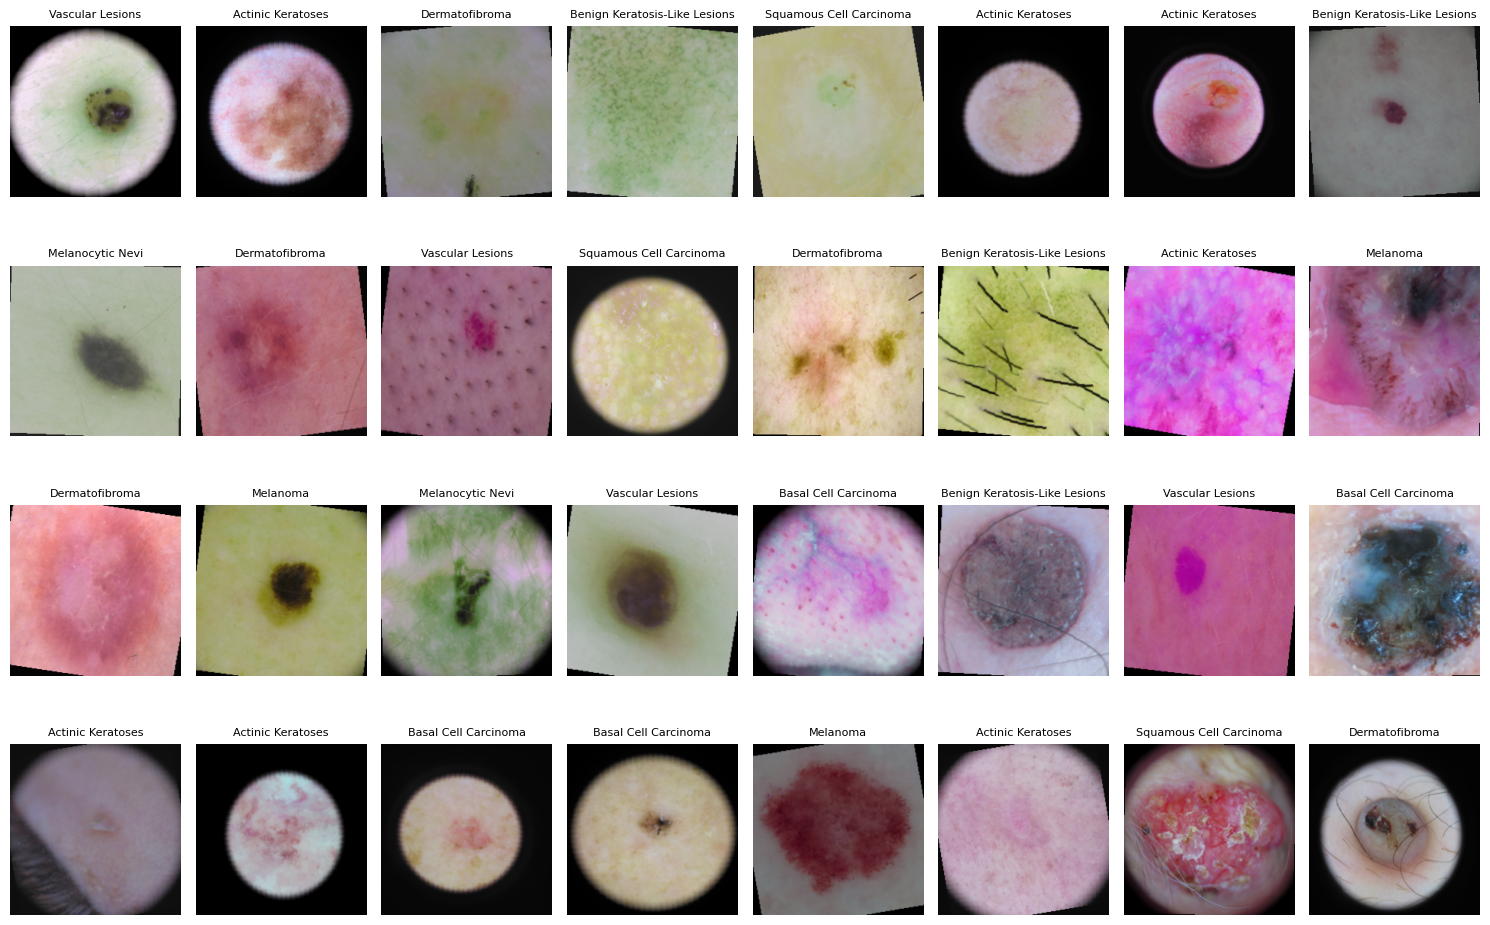

time: 5.83 s (started: 2024-08-18 19:05:12 +07:00)


In [27]:
# Function to plot a batch of images
def plot_batch_images(images, labels, label_mapping):
    num_images = len(images)
    num_cols = 8
    num_rows = math.ceil(num_images / num_cols)

    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(num_rows, num_cols, i + 1)

        img = images[i].permute(1, 2, 0).numpy()  # Convert tensor to numpy array and rearrange dimensions
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
        img = np.clip(img, 0, 1)  # Clip values to be in the range [0, 1]
        plt.imshow(img)
        plt.axis('off')

        label = labels[i].item()
        label_name = list(label_mapping.keys())[list(label_mapping.values()).index(label)]  # Get label name
        plt.title(label_name, fontsize=8)

    plt.tight_layout()
    plt.show()

# Get a batch of training data
images, labels = next(iter(train_loader))

# Plot the batch of images
plot_batch_images(images, labels, label_mapping)


##Model functionalities

###Load pre-trained and construct models

####Load pretrained models

In [28]:
def create_model(model_name, num_classes):
    if model_name == 'densenet121':
        model = models.densenet121(pretrained=True)
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Sequential(
            nn.Dropout(0.5),  # Add dropout with 50% probability
            nn.Linear(num_ftrs, num_classes)
        )
    elif model_name == 'efficientnet-b0':
        model = EfficientNet.from_pretrained('efficientnet-b0')
        num_ftrs = model._fc.in_features
        model._fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_ftrs, num_classes)
        )
    elif model_name == 'resnet101':
        model = models.resnet101(pretrained=True)
        num_ftrs = model.fc.in_features
        model.fc = nn.Sequential(
            # nn.Dropout(0.5),  # Add dropout with 50% probability
            nn.Linear(num_ftrs, num_classes)
        )
    elif model_name == 'resnext50_32x4d':
        model = models.resnext50_32x4d(pretrained=True)
        num_ftrs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(0.5),  # Add dropout with 50% probability
            nn.Linear(num_ftrs, num_classes)
        )
        model.num_classes = num_classes
    elif model_name == 'shufflenet_v2_x1_0':
        model = models.shufflenet_v2_x1_0(pretrained=True)
        num_ftrs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_ftrs, num_classes)
        )
    else:
        raise ValueError("Invalid model name. Choose from 'resnet101', 'densenet201', 'efficientnet-b5', 'resnext50_32x4d' or 'shufflenetv2'.")
    return model


time: 2.21 ms (started: 2024-08-18 19:05:18 +07:00)


###Training activities

In [29]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25, patience=5, threshold=0.5, save_dir='best_model'):
    best_val_loss = np.inf
    best_val_acc = 0.0
    patience_counter = 0
    metrics = {
        'Train Loss': [],
        'Train Accuracy': [],
        'Val Loss': [],
        'Val Accuracy': [],
        'Learning Rate': []  # Track learning rate
    }
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Start the timer
    start_time = time.time()
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", ncols=200)  # Adjust ncols to set the width
        num_batches = len(train_loader)
        validate_every_n_batches = max(1, num_batches // 10)  # Calculate the number of batches for 10% progress

        val_loss = None
        val_acc = None

        for batch_idx, (images, labels) in enumerate(progress_bar):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()  # Backpropagation
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            train_loss = running_loss / (batch_idx + 1)
            train_acc = 100 * correct / total

            if (batch_idx + 1) % validate_every_n_batches == 0 or (batch_idx + 1) == num_batches:
                val_loss, val_acc, _, _ = validate_model(model, val_loader, criterion, threshold)

            progress_bar.set_postfix({
                'Train Loss': f'{train_loss:.4f}',
                'Train Accuracy': f'{train_acc:.2f}%',
                'Val Loss': f'{val_loss:.4f}' if val_loss is not None else '[]',
                'Val Accuracy': f'{val_acc:.2f}%' if val_acc is not None else '[]'
            })
            progress_bar.refresh()

        val_loss, val_acc, all_preds, all_labels = validate_model(model, val_loader, criterion, threshold)

        # Store final metrics for the epoch
        metrics['Train Loss'].append(train_loss)
        metrics['Train Accuracy'].append(train_acc)
        metrics['Val Loss'].append(val_loss)
        metrics['Val Accuracy'].append(val_acc)
        metrics['Learning Rate'].append(optimizer.param_groups[0]['lr'])  # Track learning rate
        
        scheduler.step(val_loss)  # Step the scheduler
        
        # Early stopping
        if val_loss < best_val_loss or val_acc > best_val_acc:
            # if val_loss < best_val_loss:
            #     best_val_loss = val_loss
            # if val_acc > best_val_acc:
            #     best_val_acc = val_acc
            best_val_loss = val_loss
            best_val_acc = val_acc
            patience_counter = 0
            
            # Save the best model
            model_save_path = os.path.join(save_dir, f'{model_name}_best.pth')
            torch.save({
                'epoch': epoch + 1, # Adjust the epoch number
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'val_acc': val_acc,
                'learning_rate': optimizer.param_groups[0]['lr']  # Save learning rate
            }, model_save_path)

            # Print success message
            print(f'Model {model_name} at epoch {epoch + 1} with accuracy of {val_acc:.2f}% and loss of {val_loss:.4f} is saved to "{model_save_path}" successfully.')
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered")
            break

        
        
    # End the timer
    end_time = time.time()
    total_time = end_time - start_time

    # Print overall model accuracy on the validation set
    print(f"Overall Validation Accuracy: {val_acc:.2f}%")
    print(f"Total Training Time: {total_time:.2f} seconds")
    
    return metrics


time: 4.58 ms (started: 2024-08-18 19:05:18 +07:00)


In [30]:
def validate_model(model, val_loader, criterion, threshold=0.5):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            probabilities = torch.softmax(outputs, dim=1)
            max_probs, predicted = torch.max(probabilities, 1)
            confident_preds = (max_probs >= threshold).long() * predicted
            total += labels.size(0)
            correct += (confident_preds == labels).sum().item()

            all_preds.extend(confident_preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = running_loss / len(val_loader)
    val_acc = 100 * correct / total

    return val_loss, val_acc, all_preds, all_labels


time: 3.66 ms (started: 2024-08-18 19:05:18 +07:00)


###Complexity measurement

In [31]:
# Function to measure training time
def measure_training_time(model, train_loader, criterion, optimizer, num_epochs=1):
    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    end_time = time.time()
    training_time = end_time - start_time
    print(f"Relative Training Time of 1 Epoch: {training_time:.2f} seconds")

# Function to measure inference time
def measure_inference_time(model, test_loader):
    model.eval()
    start_time = time.time()
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
    end_time = time.time()
    inference_time = end_time - start_time
    print(f"Total Inference Time: {inference_time:.2f} seconds")

# Function to measure memory usage
def measure_memory_usage(model, train_loader):
    model.train()
    torch.cuda.reset_peak_memory_stats(device)
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    peak_memory = torch.cuda.max_memory_allocated(device)
    print(f"Peak Memory Usage: {peak_memory / (1024 ** 2):.2f} MB")

time: 3.82 ms (started: 2024-08-18 19:05:18 +07:00)


###Visualize training result

In [32]:
def plot_metrics(metrics):
    epochs = range(1, len(metrics['Train Loss']) + 1)

    # # Debugging: Print the metrics to check their contents
    # print("Train Loss:", metrics['Train Loss'])
    # print("Val Loss:", metrics['Val Loss'])
    # print("Learning Rate:", metrics['Learning Rate'])
    
    fig, ax1 = plt.subplots(1, 2, figsize=(12, 4))

    # Plotting Training and Validation Loss
    ax1[0].plot(epochs, metrics['Train Loss'], label='Train Loss')
    ax1[0].plot(epochs, metrics['Val Loss'], label='Val Loss')
    ax1[0].set_xlabel('Epochs')
    ax1[0].set_ylabel('Loss')
    ax1[0].set_title('Training and Validation Loss')

    ax2_0 = ax1[0].twinx()
    ax2_0.plot(epochs, metrics['Learning Rate'], label='Learning Rate', color='r', linestyle='--')
    ax2_0.set_ylabel('Learning Rate')

    # Combine legends for Loss
    lines_0, labels_0 = ax1[0].get_legend_handles_labels()
    lines_2_0, labels_2_0 = ax2_0.get_legend_handles_labels()
    ax1[0].legend(lines_0 + lines_2_0, labels_0 + labels_2_0, loc='upper right')

    # Plotting Training and Validation Accuracy
    ax1[1].plot(epochs, metrics['Train Accuracy'], label='Train Accuracy')
    ax1[1].plot(epochs, metrics['Val Accuracy'], label='Val Accuracy')
    ax1[1].set_xlabel('Epochs')
    ax1[1].set_ylabel('Accuracy')
    ax1[1].set_title('Training and Validation Accuracy')

    ax2_1 = ax1[1].twinx()
    ax2_1.plot(epochs, metrics['Learning Rate'], label='Learning Rate', color='r', linestyle='--')
    ax2_1.set_ylabel('Learning Rate')

    # Combine legends for Accuracy
    lines_1, labels_1 = ax1[1].get_legend_handles_labels()
    lines_2_1, labels_2_1 = ax2_1.get_legend_handles_labels()
    ax1[1].legend(lines_1 + lines_2_1, labels_1 + labels_2_1, loc='upper left')

    plt.tight_layout()
    plt.show()


time: 2.31 ms (started: 2024-08-18 19:05:18 +07:00)


In [33]:
def visualize_predictions(model, val_loader, label_mapping, criterion, num_images=16):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 15))  # Decrease the figure size

    with torch.no_grad():
        for i, (images, labels) in enumerate(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            for j in range(images.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 4, 4, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {list(label_mapping.keys())[preds[j]]}\n'
                             f'Actual: {list(label_mapping.keys())[labels[j]]}\n'
                             f'Loss: {loss.item():.2f}\n'
                             f'Accuracy: {(preds[j] == labels[j]).item() * 100:.2f}%', fontsize=14)  # Increase text size
                img = images.cpu().data[j].numpy().transpose((1, 2, 0))
                img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
                img = np.clip(img, 0, 1)
                ax.imshow(img)

                if images_so_far == num_images:
                    plt.tight_layout()
                    return


time: 2.62 ms (started: 2024-08-18 19:05:18 +07:00)


In [34]:
def plot_confusion_matrix(model, test_loader, label_mapping):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    cm_labels = list(label_mapping.keys())

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cm_labels, yticklabels=cm_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

time: 3.78 ms (started: 2024-08-18 19:05:18 +07:00)


In [35]:
def plot_normalize_confusion_matrix(model, test_loader, label_mapping):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    cm_labels = list(label_mapping.keys())

    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot normalized confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=cm_labels, yticklabels=cm_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Normalized Confusion Matrix')
    plt.show()

time: 2.57 ms (started: 2024-08-18 19:05:18 +07:00)


##Train the model

In [ ]:
# Construct the model for training process
num_classes = len(label_mapping)

model_name = 'resnet101'
model = create_model(model_name, num_classes)
model = model.to(device)  # Move the model to the device

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Transfer learning model
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# Configuration for training process
num_epochs = 100
threshold = 0.5
patience = 10
save_dir = '../saved_models_2'  # Save the best model to this location

# Start training
metrics = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience=patience, threshold=threshold, save_dir=save_dir)

Epoch 1/100: 100%|███████████████████████████████████████████████████████████████████| 1949/1949 [45:41<00:00,  1.41s/it, Train Loss=1.9988, Train Accuracy=20.91%, Val Loss=1.9254, Val Accuracy=4.74%]


Model resnet101 at epoch 1 with accuracy of 4.83% and loss of 1.9284 is saved to "../saved_models_2/resnet101_best.pth" successfully.


Epoch 3/100: 100%|███████████████████████████████████████████████████████████████████| 1949/1949 [46:22<00:00,  1.43s/it, Train Loss=1.8923, Train Accuracy=26.33%, Val Loss=1.7377, Val Accuracy=4.32%]


Model resnet101 at epoch 3 with accuracy of 4.22% and loss of 1.7359 is saved to "../saved_models_2/resnet101_best.pth" successfully.


Epoch 4/100: 100%|███████████████████████████████████████████████████████████████████| 1949/1949 [45:55<00:00,  1.41s/it, Train Loss=1.8383, Train Accuracy=28.10%, Val Loss=1.8044, Val Accuracy=6.43%]


Model resnet101 at epoch 4 with accuracy of 6.52% and loss of 1.8130 is saved to "../saved_models_2/resnet101_best.pth" successfully.


Epoch 5/100: 100%|██████████████████████████████████████████████████████████████████| 1949/1949 [45:28<00:00,  1.40s/it, Train Loss=1.7944, Train Accuracy=30.28%, Val Loss=1.6196, Val Accuracy=19.15%]


Model resnet101 at epoch 5 with accuracy of 18.21% and loss of 1.6290 is saved to "../saved_models_2/resnet101_best.pth" successfully.


Epoch 6/100: 100%|██████████████████████████████████████████████████████████████████| 1949/1949 [45:45<00:00,  1.41s/it, Train Loss=1.6949, Train Accuracy=34.39%, Val Loss=1.6202, Val Accuracy=17.22%]


Model resnet101 at epoch 6 with accuracy of 17.27% and loss of 1.6254 is saved to "../saved_models_2/resnet101_best.pth" successfully.


Epoch 7/100: 100%|██████████████████████████████████████████████████████████████████| 1949/1949 [44:55<00:00,  1.38s/it, Train Loss=1.6015, Train Accuracy=38.35%, Val Loss=1.4302, Val Accuracy=29.14%]


Model resnet101 at epoch 7 with accuracy of 28.16% and loss of 1.4338 is saved to "../saved_models_2/resnet101_best.pth" successfully.


Epoch 10/100: 100%|█████████████████████████████████████████████████████████████████| 1949/1949 [45:28<00:00,  1.40s/it, Train Loss=1.3950, Train Accuracy=46.57%, Val Loss=1.4862, Val Accuracy=29.66%]


Model resnet101 at epoch 10 with accuracy of 30.22% and loss of 1.4695 is saved to "../saved_models_2/resnet101_best.pth" successfully.


Epoch 11/100: 100%|█████████████████████████████████████████████████████████████████| 1949/1949 [45:01<00:00,  1.39s/it, Train Loss=1.3401, Train Accuracy=48.49%, Val Loss=1.3652, Val Accuracy=33.83%]


Model resnet101 at epoch 11 with accuracy of 32.99% and loss of 1.3581 is saved to "../saved_models_2/resnet101_best.pth" successfully.


Epoch 12/100:  41%|██████████████████████████▊                                       | 790/1949 [18:12<24:34,  1.27s/it, Train Loss=1.3121, Train Accuracy=49.66%, Val Loss=1.4474, Val Accuracy=28.25%]IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=10.0 (secs)

Epoch 20/100: 100%|█████████████████████████████████████████████████████████████████| 1949/1949 [44:27<00:00,  1.37s/it, Train Loss=1.0733, Train Accuracy=59.20%, Val Loss=1.2787, Val Accuracy=39.37%]


Epoch    20: reducing learning rate of group 0 to 1.0000e-04.


Epoch 21/100: 100%|█████████████████████████████████████████████████████████████████| 1949/1949 [44:40<00:00,  1.38s/it, Train Loss=0.9561, Train Accuracy=63.71%, Val Loss=1.2322, Val Accuracy=42.42%]


Model resnet101 at epoch 21 with accuracy of 42.14% and loss of 1.2538 is saved to "../saved_models_2/resnet101_best.pth" successfully.


Epoch 22/100: 100%|█████████████████████████████████████████████████████████████████| 1949/1949 [44:53<00:00,  1.38s/it, Train Loss=0.9319, Train Accuracy=64.57%, Val Loss=1.2007, Val Accuracy=41.34%]


Model resnet101 at epoch 22 with accuracy of 42.37% and loss of 1.1839 is saved to "../saved_models_2/resnet101_best.pth" successfully.


Epoch 26/100: 100%|█████████████████████████████████████████████████████████████████| 1949/1949 [48:59<00:00,  1.51s/it, Train Loss=0.8829, Train Accuracy=66.44%, Val Loss=1.2103, Val Accuracy=42.89%]


Epoch    26: reducing learning rate of group 0 to 1.0000e-05.
Model resnet101 at epoch 26 with accuracy of 42.89% and loss of 1.2439 is saved to "../saved_models_2/resnet101_best.pth" successfully.


Epoch 28/100: 100%|█████████████████████████████████████████████████████████████████| 1949/1949 [51:10<00:00,  1.58s/it, Train Loss=0.8874, Train Accuracy=66.62%, Val Loss=1.2591, Val Accuracy=40.87%]


Model resnet101 at epoch 28 with accuracy of 40.54% and loss of 1.2330 is saved to "../saved_models_2/resnet101_best.pth" successfully.


Epoch 29/100: 100%|█████████████████████████████████████████████████████████████████| 1949/1949 [51:28<00:00,  1.58s/it, Train Loss=0.8792, Train Accuracy=66.70%, Val Loss=1.2382, Val Accuracy=41.81%]


Model resnet101 at epoch 29 with accuracy of 41.06% and loss of 1.2169 is saved to "../saved_models_2/resnet101_best.pth" successfully.


Epoch 34/100: 100%|█████████████████████████████████████████████████████████████████| 1949/1949 [53:01<00:00,  1.63s/it, Train Loss=0.9403, Train Accuracy=64.85%, Val Loss=1.2372, Val Accuracy=38.01%]


Epoch    34: reducing learning rate of group 0 to 1.0000e-07.


Epoch 38/100: 100%|█████████████████████████████████████████████████████████████████| 1949/1949 [51:48<00:00,  1.60s/it, Train Loss=1.0065, Train Accuracy=62.60%, Val Loss=1.3071, Val Accuracy=32.94%]


Epoch    38: reducing learning rate of group 0 to 1.0000e-08.


Epoch 39/100:  19%|████████████▊                                                     | 379/1949 [08:56<33:33,  1.28s/it, Train Loss=1.0407, Train Accuracy=61.24%, Val Loss=1.2959, Val Accuracy=32.90%]

##Complexity measurement

In [ ]:
# Measure training time
measure_training_time(model, train_loader, criterion, optimizer, num_epochs=1)

# Measure memory usage during training
measure_memory_usage(model, train_loader)

# Measure inference time
measure_inference_time(model, test_loader)

##Visualize training result

In [ ]:
# Visualize the metrics
plot_metrics(metrics)

In [ ]:
# Visualize predictions
visualize_predictions(model, val_loader, label_mapping, criterion, num_images=16)

In [ ]:
# Plot the confusion matrix
plot_confusion_matrix(model, test_loader, label_mapping)

In [ ]:
# Plot the normalized confusion matrix
plot_normalize_confusion_matrix(model, test_loader, label_mapping)